# Graph Neural Network
---
> Graph neural network model for vertex dynamics and tension prediction

**To-Do**👷🚧

- *Training loop*:
    - [ ] Combine `Message` and `AggregateUpdate` into a graph layer `GraphBlock`
- [ ] Write *prediction stage*: read \{test, val, train\} data and predict w/ saving. 1-step and rollout error measurements.
- [ ] Run more simul-s. Save them as both 1-frame and rollout datasets (in rollout dataset keep each movie as a seperate dataset).
- [ ] Experiments (**save all models** w/ backups; will need to test on the real tensions)<br>
*Params*: edge attrib-s, cell layer, arch(skip con-s), input noise (for long term prediction). *Errors*: 1-step, and rollout error (check after training at test time).
    1. Experiment with GN arch-s w/ *residual* (w/ skip) and *non-residual* architectures.
    1. Find a *rough number of layers* (Mess. passing steps) and hidden *dim-s sizes* for var-s. --> Initial estimates for next experiments.
    1. *Edge directions experiment*: train w/ and w/o edge dir-s, do edge dir-s help to speed up training?
    1. *Cell layer*: does having dedicated cell processing layer help to increase the accuracy?
    1. For best (resnet or non-resnet) run *number of layers and dim-n sizes*. Try deep nets, how does accuracy change with increasing the depth of the net?
    1. If resnet is better: try w/and w/o edge dir-s and "cell layers".
    1. Number of previous velocities (window size).
    1. Rollout experiment 1— *input noise*: according to Sanchez-Gonzalez, *et al.* \[ASG2020\], Brownian noise improves rollout accuracies (long term accuracy of the whole movie, and/or prediction stability/robustness).
    1. Rollout experiment 2— *rollout training*: train directly on rollout, i.e. use 5- and 10-step loss instead of a 1-step loss for training (slower training).
    1. Optional:
        - compare MLP vs CONV layers for message passing.
        - try with dynamic graphs (construct graphs on the fly based on relative positions, and use cell edges and cell attrib only for queries on `Y_edge`, `Y_cell`).
- [ ] Ablation dataset (*real*).

---
**DOING**🛠
1. Training loop w/ validation set error monitoring, and best model saving.
1. Construct graph net without skip connections.
1. Combine Message and AggregateUpdate into a graph layer GraphNet (GN) block, a more general block, that can be composed into a deep residual network. "AddGN" block, w/ `AddGN(x) = f(x)+x` form (in fact, where it's possible make all blocks with this form.
1. Construct residual net out of GNs.
---

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import torch
from os import path
import datetime

from torch_geometric.data import Data, DataLoader
import torch_geometric.transforms as T

from torch_geometric.utils import to_networkx, from_networkx
import networkx as nx
from simgnn.datautils import load_array, load_graph

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10,10) # use larger for presentation
matplotlib.rcParams['font.size']= 16 # use 14 for presentation

In [5]:
from simgnn.datasets import persistence_loss, VertexDynamics, HaraMovies
from simgnn.train import train_model, write_log, load_log
from simgnn.nn import Plain_MLP, mlp, Message, AggregateUpdate, Aggregate
from simgnn.transforms import Pos2Vec, ScaleVelocity, ScaleTension, ScalePressure, Reshape_x
# from torch_geometric.utils import to_undirected as T_undir

In [6]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
dtype = torch.float32
print(f'Defaults:\n |-device: {device}\n |-dtype : {dtype}')

Defaults:
 |-device: cpu
 |-dtype : torch.float32


## Datasets

---
- Data pre-processing and normalisation:
    - Simulation datasets: `l_av=0.857`
        - `Pos2Vec(scale=10*0.857)`
        - `ScaleVelocity(0.5*0.857)`
        - `ScaleTension(5,shift=1.45)`
        - `ScalePressure(3, shift=1.0)`

    - Hara movies: `l_av=26.32`
        - `Pos2Vec(scale=10*26.32)`
        - `ScaleVelocity(0.5*26.32)`

### Hara Movies Dataset (no force information)

HaraMovies(165)

Frame 1:
CellData(cell2node_index=[2, 492], edge_attr=[225, 2], edge_index=[2, 225], node2cell_index=[2, 492], pos=[164, 2], x=[164, 5, 2], y=[164, 2])


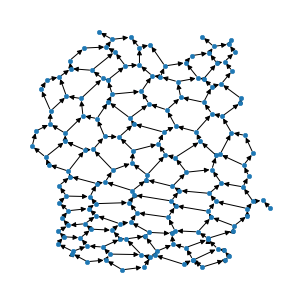

In [26]:
T_hara_norm = T.Compose([Pos2Vec(scale=10*26.32) , ScaleVelocity(0.5*26.32)]) # data normalisation

hara_movs = HaraMovies('simgnn_data/hara_movies/', transform=T_hara_norm)
mov_i = hara_movs[0]

print('{}\n\nFrame 1:\n{}'.format(hara_movs,mov_i))
plt.figure(figsize=[4,4])
nx.draw(to_networkx(mov_i),pos=dict(enumerate(mov_i.pos.numpy())), node_size=20)

### Synthetic Datasets (Train , and Val)

VertexDynamics(95) 
 CellData(cell2node_index=[2, 600], cell_pressures=[100], edge_attr=[339, 2], edge_index=[2, 339], edge_tensions=[339], node2cell_index=[2, 600], pos=[240, 2], x=[240, 5, 2], y=[240, 2])


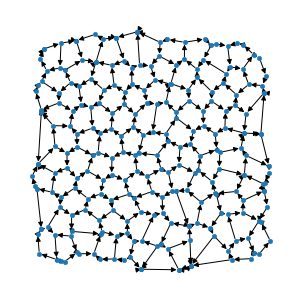

In [121]:
# Normalisation: for simulated data
Tnorm = T.Compose([Pos2Vec(scale=10*0.857) , ScaleVelocity(0.5*0.857), ScaleTension(5,shift=1.45),  ScalePressure(3, shift=1.0)])

# training dataset
vtxdata = VertexDynamics('../../../dataDIR/simgnn_data/train/', transform=Tnorm)
# validation dataset (also simulation): val = VertexDynamics('../../../dataDIR/simgnn_data/val/')

print(vtxdata,'\n',vtxdata[0])
plt.figure(figsize=[4,4])
nx.draw(to_networkx(vtxdata[0]),pos=dict(enumerate(vtxdata[0].pos.numpy())), node_size=20)

In [123]:
vtxdata.len()

95

## Training

- [Pytorch reproducibility ](https://pytorch.org/docs/stable/notes/randomness.html)

- need a func-n w/ a **rollout error**,
- need to convert vel-y error to **position error**

In [7]:
# Normalisation: for simulated data: l0=0.857, Hara_movie: l0=26.32
Tnorm = T.Compose([Pos2Vec(scale=10*0.857) , ScaleVelocity(0.5*0.857),
                   ScaleTension(5,shift=1.45),  ScalePressure(3, shift=1.0),
                  Reshape_x((-1,10))])
Tnorm_hara = T.Compose([Pos2Vec(scale=10*26.32) , ScaleVelocity(0.5*26.32),
                        Reshape_x((-1,10))]) # Hara movie dataset norm

# Datasets
train_dataset = VertexDynamics('./simgnn_data/train/', transform=Tnorm)
val_dataset = VertexDynamics('./simgnn_data/val/', transform=Tnorm)
hara_movies = HaraMovies('simgnn_data/hara_movies/', transform=Tnorm_hara)

`CellData` prop-s (graph data objects):
- `x` : `(#nodes, WindowWidth, 2)` *node features*
- `y` : `(#nodes, 2)` *node targets (velocities)*.
- `pos` : `(#nodes, 2)` *node positions*.
- `edge_attr` : `(#edges, 2)` or `(#edges, #edge_features)` *edge features  (relative Cartesian positions of connected nodes)*.
- `edge_index` : `(2, #edges)` *edge indices*.
- `edge_tensions` : `(#edges,)` *edge targets (line tensions)*.
- `node2cell_index` : `(2, #cell2node_edges)`, `node2cell`-> *first row is node indices and second row is cell indices;
- `cell2node_index` : `(2, #cell2node_edges)`, `cell2node`-> *first row is cell indices and second row is node indices*.
- `cell_pressures` : `(#cells,)` *cell targets (cell pressures)*.

**Node-to-Cell Encoding/Pooling Layer**:
1. Initiate node-to-cell edge attr-s as (source) node attr-s `x[node2cell_index[0]]`.
1. Compute node-to-cell edge attr-s using MLP: `e_n2c = MLP( x[node2cell_index[0]] )`
1. Aggregate node-to-cell edge attr-s as cell attr-s : `x_cell = Aggregate(e_n2c)`
1. Compute new cell attr-s using (encodes `x_cell` into cell attr-s) : `h_cell = MLP_Cell_encoder( x_cell )`

```python
n2c_model = mlp(...) # "message", just node-wise MLP
cell_aggr = Aggregate()
cell_enc = mlp(...)

e_n2c = n2c_model(data.x)[data.node2cell_index[0]]
x_cell = cell_aggr(data.cell_pressures.size(0), data.node2cell_index, e_n2c)
h_cell = cell_enc(x_cell)
```

In [17]:
torch.manual_seed(0)

net = Plain_MLP(in_features=10, out_features=2, hidden_dims=[10,5])

num_epochs = 30
lr = 0.001
bs = 8
MSE_loss = torch.nn.MSELoss(reduction='mean')
opt = torch.optim.Adam(net.parameters(), lr=lr)
# opt = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min')

# in order to track the batch id for var-s add its key to "follow_batch":
loaders = {'train' : DataLoader(train_dataset, batch_size=bs,follow_batch=['cell_pressures','edge_index']),
          'val': DataLoader(val_dataset, batch_size=bs,follow_batch=['cell_pressures','edge_index']),
          'hara': DataLoader(hara_movies, batch_size=bs)}
# this tracks batch id for "cell_pressures_batch" and "edge_index_batch" in addition to node batch ids

model_states = list(loaders.keys())
use_force_loss = {k:[False,False] for k in loaders}

model_name = datetime.datetime.now().strftime('%d%m%Y_%H%M')+f'_bs{bs}'
save_dir = '.'

---
- **Adding noise from M steps**: Sum of M normal rand. var-s results in normal var. w/ variance M and s.t.d.=sqrt(M):
```python
x = np.random.normal(size=(5,1000))
y = x.sum(axis=0)
z = np.random.normal(size=(1,1000))*np.sqrt(5)
plt.hist(x.ravel(),bins=50,label='x',density=True)
plt.hist(y        ,bins=50,label='y',density=True)
plt.hist(z.ravel(),bins=50,label='z',density=True,alpha=.5)
plt.legend();
```

Training param-s: #epochs=30, metric=MSELoss(), optim=Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
), sch-r=none, return_best=False
---
Epoch 0/29: train_loss_tot=0.0427; train_loss_y=0.0427; |val_loss_tot=0.0416; val_loss_y=0.0416; |hara_loss_tot=0.0436; hara_loss_y=0.0436; |1s
Epoch 1/29: train_loss_tot=0.0390; train_loss_y=0.0390; |val_loss_tot=0.0379; val_loss_y=0.0379; |hara_loss_tot=0.0398; hara_loss_y=0.0398; |2s
Epoch 2/29: train_loss_tot=0.0350; train_loss_y=0.0350; |val_loss_tot=0.0334; val_loss_y=0.0334; |hara_loss_tot=0.0352; hara_loss_y=0.0352; |3s
Epoch 3/29: train_loss_tot=0.0302; train_loss_y=0.0302; |val_loss_tot=0.0285; val_loss_y=0.0285; |hara_loss_tot=0.0302; hara_loss_y=0.0302; |4s
Epoch 4/29: train_loss_tot=0.0254; train_loss_y=0.0254; |val_loss_tot=0.0239; val_loss_y=0.0239; |hara_loss_tot=0.0255; hara_loss_y=0.0255; |4s
Epoch 5/29: train_loss_tot=0.0210; train_loss_y=0.0210; |val_loss_tot=0.

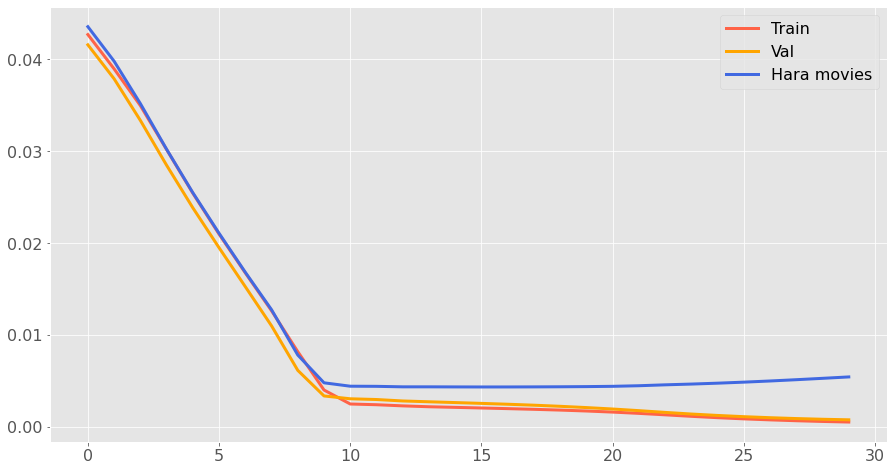

In [19]:
net, train_log = train_model(net, loaders, opt, num_epochs=num_epochs, scheduler=None, device=device, model_states = model_states,
                               loss_func = MSE_loss, use_force_loss=use_force_loss,
                               return_best=False)
plt.figure(figsize=[15,8])
plt.plot(np.arange(train_log['total_epochs']),train_log['train_loss_tot'],'tomato',lw=3,label='Train')
plt.plot(np.arange(train_log['total_epochs']),train_log['val_loss_tot'],'orange',lw=3,label='Val')
plt.plot(np.arange(train_log['total_epochs']),train_log['hara_loss_tot'],'royalblue',lw=3,label='Hara movies')
plt.legend();

write_log(f'{path.join(save_dir, model_name)}_train_log.pkl',train_log)
torch.save(net.state_dict(), f'{path.join(save_dir, model_name)}_net.pkl')

- **Examples**:
    - General "Message Passing" schemes: a nice example for composite graph layer –"meta layer" consisting of "edge", "node" and "global" layers [link](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.meta.MetaLayer)

In [122]:
# for graph_dataset in [train_dataset, val_dataset, hara_movies]:
#     print(f'Persistence {graph_dataset.__class__.__name__}: {persistence_loss(graph_dataset)}')